<a href="https://colab.research.google.com/github/mlej8/ECSE552/blob/main/Tutorials/T10B_CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style Transfer with CycleGAN Part 2

This notebook tries to improve on the previous [CycleGAN tutorial](https://colab.research.google.com/drive/1G47rclcyrS-tzdWlK-qdvWN5T_3FGteP?usp=sharing). The difference is that we are utiling the labels given in the datasets.

# Dataset Preparation

In [ ]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
import numpy as np
import random
import os

batch_size=64

transform = transforms.Compose([
                transforms.Resize(32),
                transforms.ToTensor(),])

os.mkdir('data')

svhn = datasets.SVHN(root='data/', download=True, transform=transform)
mnist = datasets.MNIST(root='data/', download=True, transform=transform)

svhn_loader = torch.utils.data.DataLoader(dataset=svhn,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)

mnist_loader = torch.utils.data.DataLoader(dataset=mnist,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=2)


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
SEED=2
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

Let us look at some of the samples in the dataset

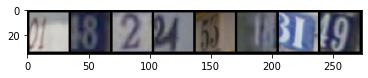

In [ ]:
import matplotlib.pyplot as plt

dataiter = iter(svhn_loader)
images, labels = dataiter.next()
img = images[:8]
img = torchvision.utils.make_grid(img) # this just compiles our data in a single image
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0))) # channel dimension is last
plt.show()

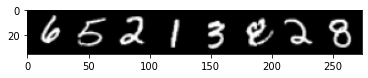

In [ ]:
dataiter = iter(mnist_loader)
images, labels = dataiter.next()
img = images[:8]
img = torchvision.utils.make_grid(img) # this just compiles our data in a single image
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0))) # channel dimension is last
plt.show()

So our task is to make the "clean" MNIST samples look like a "real" image make the "noisy" SVHN samples like MNIST.


# CycleGAN Network Components

First, we need to define the architecture. Our CycleGAN is composed of 4 components:
- MNIST to SVHN transformer
- SVHN to MNIST transformer
- MNIST discriminator
- SVHN discriminator

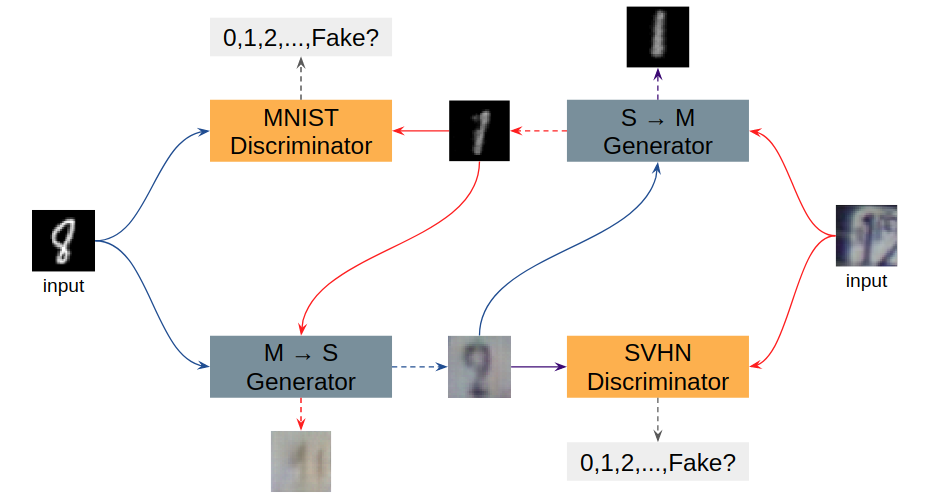

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, conv_dim=64):
        super(Generator, self).__init__()
        # encoder
        self.conv1 = nn.Conv2d(in_channels, conv_dim, 4, 2, 1)
        self.bn1 = nn.BatchNorm2d(conv_dim)
        self.conv2 = nn.Conv2d(conv_dim, conv_dim*2, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(conv_dim*2)
        self.conv3 = nn.Conv2d(conv_dim*2, conv_dim*2, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(conv_dim*2)
        self.conv4 = nn.Conv2d(conv_dim*2, conv_dim*2, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(conv_dim*2)
        
        # decoder
        self.deconv1 = nn.ConvTranspose2d(conv_dim*2, conv_dim, 4, 2, 1)
        self.bn5 = nn.BatchNorm2d(conv_dim)
        self.deconv2 = nn.ConvTranspose2d(conv_dim, out_channels, 4, 2, 1)
        
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x))      # (-1, 64, 16, 16)
        out = self.bn1(out)
        out = F.leaky_relu(self.conv2(out))    # (-1, 128, 8, 8)
        out = self.bn2(out)
        out = F.leaky_relu(self.conv3(out))    # (-1, 128, 8, 8)
        out = self.bn3(out)
        out = F.leaky_relu(self.conv4(out))    # (-1, 128, 8, 8)
        out = self.bn4(out)
        
        out = F.leaky_relu(self.deconv1(out))  # (-1, 64, 16, 16)
        out = self.bn5(out)
        out = torch.relu(self.deconv2(out))    # (-1, 3, 32, 32)
        return out


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, conv_dim=64):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, conv_dim, 4, 2, 1)
        self.conv2 = nn.Conv2d(conv_dim, conv_dim*2, 4, 2, 1)
        self.conv3 = nn.Conv2d(conv_dim*2, conv_dim*2, 4, 2, 1)
        self.disc_out = nn.Conv2d(conv_dim*2, 11, 4, 1, 0)
        
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x))    # (-1, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out))  # (-1, 128, 8, 8)
        out = F.leaky_relu(self.conv3(out))  # (-1, 256, 4, 4)
        out = self.disc_out(out).squeeze()
        return out

Let's initialize the network and define the optimizers. Take note that we have 2 optimizers with mutually exclusive set of parameters to optimize.

In [ ]:
from torch import optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

m2s = Generator(in_channels=1, out_channels=3).to(device)
s2m = Generator(in_channels=3, out_channels=1).to(device)
dm = Discriminator(in_channels=1).to(device)
ds = Discriminator(in_channels=3).to(device)
        
g_params = list(m2s.parameters()) + list(s2m.parameters())
d_params = list(dm.parameters()) + list(ds.parameters())
        
g_optimizer = optim.Adam(g_params, 1e-4, [0.5,0.999])
d_optimizer = optim.Adam(d_params, 2e-4, [0.5,0.999])

The idea of labeled CycleGAN is that the image is well-translated if:
- the transformed image can be translated back to its own style with minimal reconstruction error
- **the discriminator can correctly classify the transformed image in terms of its true label** without being tagged as "fake"


## Training the discriminator

We have two discriminators, one for SVHN and another for MNIST. The goal of these discriminators are to classify the sample with their correct labels (if it is a real sample) or classify the sample as fake.

In [ ]:
def train_discriminator(svhn, mnist, s_labels, m_labels):
    dm.train()
    ds.train()
    s2m.train()
    m2s.train()
    
    g_optimizer.zero_grad()
    d_optimizer.zero_grad()

    fake_mnist = s2m(svhn)
    fake_svhn = m2s(mnist)
    
    mnist_ = torch.cat([mnist, fake_mnist], axis=0)
    svhn_ = torch.cat([svhn, fake_svhn], axis=0)
    
    pred_m = dm(mnist_)
    pred_s = ds(svhn_)
#     d_real_loss = discriminator_loss(pred_m[:batch_size], pred_s[:batch_size], 1) # first half are real images
#     d_fake_loss = discriminator_loss(pred_m[batch_size:], pred_s[batch_size:], 0) # second half are fake ones

    mnist_fake_labels = torch.Tensor([10]*svhn.size(0)).long().to(device) # fakes are labeled as class-10
    svhn_fake_labels = torch.Tensor([10]*mnist.size(0)).long().to(device) 
    m_labels = torch.cat([m_labels, mnist_fake_labels], axis=0)
    s_labels = torch.cat([s_labels, svhn_fake_labels], axis=0)
    
#     d_loss = d_real_loss + d_fake_loss
    d_loss = F.cross_entropy(pred_s, s_labels) + F.cross_entropy(pred_m, m_labels)
    d_loss.backward()
    d_optimizer.step()
    
    return d_loss

## Training the Generator


Training the generator is a bit more complex because it has to satisfy the two criteria above. First, the generator must be able to transform the samples such that **the discriminator would not classify it as "fake" and would correctly predict its label**.

Second, the complementary generator must be able to reverse the transformation process. You can think of it as similar to an autoencoder but there is no dimensionality reduction.


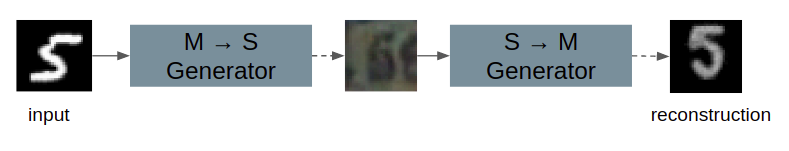

In [ ]:
def train_generator(svhn, mnist, s_labels, m_labels):
    dm.train()
    ds.train()
    s2m.train()
    m2s.train()
    
    g_optimizer.zero_grad()
    d_optimizer.zero_grad()
    
    fake_svhn = m2s(mnist)
    out = ds(fake_svhn)
    reconst_mnist = s2m(fake_svhn)
    
    #mnist_g_loss = torch.mean((out-1)**2)
    mnist_g_loss = F.cross_entropy(out, m_labels)
    mnist_recons_loss = torch.mean((mnist - reconst_mnist)**2)
     
    fake_mnist = s2m(svhn)
    out = dm(fake_mnist)
    reconst_svhn = m2s(fake_mnist)
    svhn_g_loss = F.cross_entropy(out, s_labels)
    #svhn_g_loss = torch.mean((out-1)**2)
    svhn_recons_loss = torch.mean((svhn - reconst_svhn)**2)

    g_loss = mnist_g_loss + mnist_recons_loss + svhn_g_loss + svhn_recons_loss
    g_loss.backward()
    g_optimizer.step()
    
    return g_loss

## Finally, we can define our training loop

In [ ]:
os.mkdir('samples-2')

In [ ]:
def train(svhn_loader, mnist_loader, train_iters):
    svhn_iter = iter(svhn_loader)
    mnist_iter = iter(mnist_loader)
    iter_per_epoch = min(len(svhn_iter), len(mnist_iter))

    # Select some random samples for visual validation since we do not have a test set
    fixed_svhn = svhn_iter.next()[0].to(device)
    fixed_mnist = mnist_iter.next()[0].to(device)


    for step in range(train_iters+1):

        # reset data_iter for each epoch
        if (step+1) % iter_per_epoch == 0:
            mnist_iter = iter(mnist_loader)
            svhn_iter = iter(svhn_loader)

        # load svhn and mnist dataset
        svhn, s_labels = svhn_iter.next() 
        svhn, s_labels = svhn.to(device), s_labels.to(device)
        mnist, m_labels = mnist_iter.next() 
        mnist, m_labels = mnist.to(device), m_labels.to(device)

        # Train step
        d_loss = train_discriminator(svhn, mnist, s_labels, m_labels)
        g_loss = train_generator(svhn, mnist, s_labels, m_labels)
        
        # print the log info
        if (step+1) % 200 == 0:
            print('Step [%d/%d], d_loss: %.4f, g_loss: %.4f' 
                  %(step+1, train_iters, d_loss.item(), g_loss.item()))

        # save the sampled images for visual inspection
        if (step+1) % 1000 == 0:
            s2m.eval()
            m2s.eval()
            fake_svhn = m2s(fixed_mnist)
            fake_mnist = s2m(fixed_svhn)

            vis_m2s = make_grid(fixed_mnist, fake_svhn)
            path = os.path.join('samples-2', 'sample-%d-m-s.png' %(step+1))
            #print(vis_m2s)
            #imageio.imwrite(path, vis_m2s)
            vis_m2s.save(path)
            print ('saved %s' %path)

            vis_s2m = make_grid(fixed_svhn, fake_mnist)
            path = os.path.join('samples-2', 'sample-%d-s-m.png' %(step+1))
            #imageio.imwrite(path, vis_s2m)
            vis_s2m.save(path)
            print ('saved %s' %path)

    return fake_mnist, fake_svhn, vis_m2s, vis_s2m

In [ ]:
def make_grid(sources, targets, k=10):
    if sources.shape[1] == 1:
        sources = torch.repeat_interleave(sources, 3, 1)
    if targets.shape[1] == 1:
        targets = torch.repeat_interleave(targets, 3, 1)
    b,_,h,w = sources.shape
    img = torch.cat([sources.unsqueeze(1), targets.unsqueeze(1)], axis=1)
    img = img.view(2*b,3,h,w)
    img = torchvision.utils.make_grid(img).cpu().detach()#.numpy().transpose(1,2,0)
    return transforms.ToPILImage()(img).convert("RGB")

In [ ]:
fake_mnist, fake_svhn, vis_m2s, vis_s2m = train(svhn_loader, mnist_loader, 10000)

Step [200/10000], d_loss: 2.0534, g_loss: 8.5640
Step [400/10000], d_loss: 1.8196, g_loss: 10.4899
Step [600/10000], d_loss: 1.8920, g_loss: 9.3885
Step [800/10000], d_loss: 2.4004, g_loss: 7.9927
Step [1000/10000], d_loss: 1.9553, g_loss: 8.6968
saved samples-2/sample-1000-m-s.png
saved samples-2/sample-1000-s-m.png
Step [1200/10000], d_loss: 1.9207, g_loss: 7.8608
Step [1400/10000], d_loss: 2.0021, g_loss: 7.6734
Step [1600/10000], d_loss: 1.6930, g_loss: 6.9880
Step [1800/10000], d_loss: 1.8483, g_loss: 5.2572
Step [2000/10000], d_loss: 1.6643, g_loss: 6.2265
saved samples-2/sample-2000-m-s.png
saved samples-2/sample-2000-s-m.png
Step [2200/10000], d_loss: 1.3017, g_loss: 5.7208
Step [2400/10000], d_loss: 1.5073, g_loss: 6.1059
Step [2600/10000], d_loss: 1.5200, g_loss: 6.5265
Step [2800/10000], d_loss: 1.3064, g_loss: 5.0365
Step [3000/10000], d_loss: 1.4114, g_loss: 4.9603
saved samples-2/sample-3000-m-s.png
saved samples-2/sample-3000-s-m.png
Step [3200/10000], d_loss: 1.2129, g_

In [ ]:
svhn_iter = iter(svhn_loader)
mnist_iter = iter(mnist_loader)
iter_per_epoch = min(len(svhn_iter), len(mnist_iter))

# Select some random samples fir visual validation
fixed_svhn = svhn_iter.next()[0].to(device)
fixed_mnist = mnist_iter.next()[0].to(device)

s2m.eval()
m2s.eval()
fake_svhn = m2s(fixed_mnist)
fake_mnist = s2m(fixed_svhn)

mergedm2s = make_grid(fixed_mnist, fake_svhn)
mergeds2m = make_grid(fixed_svhn, fake_mnist)

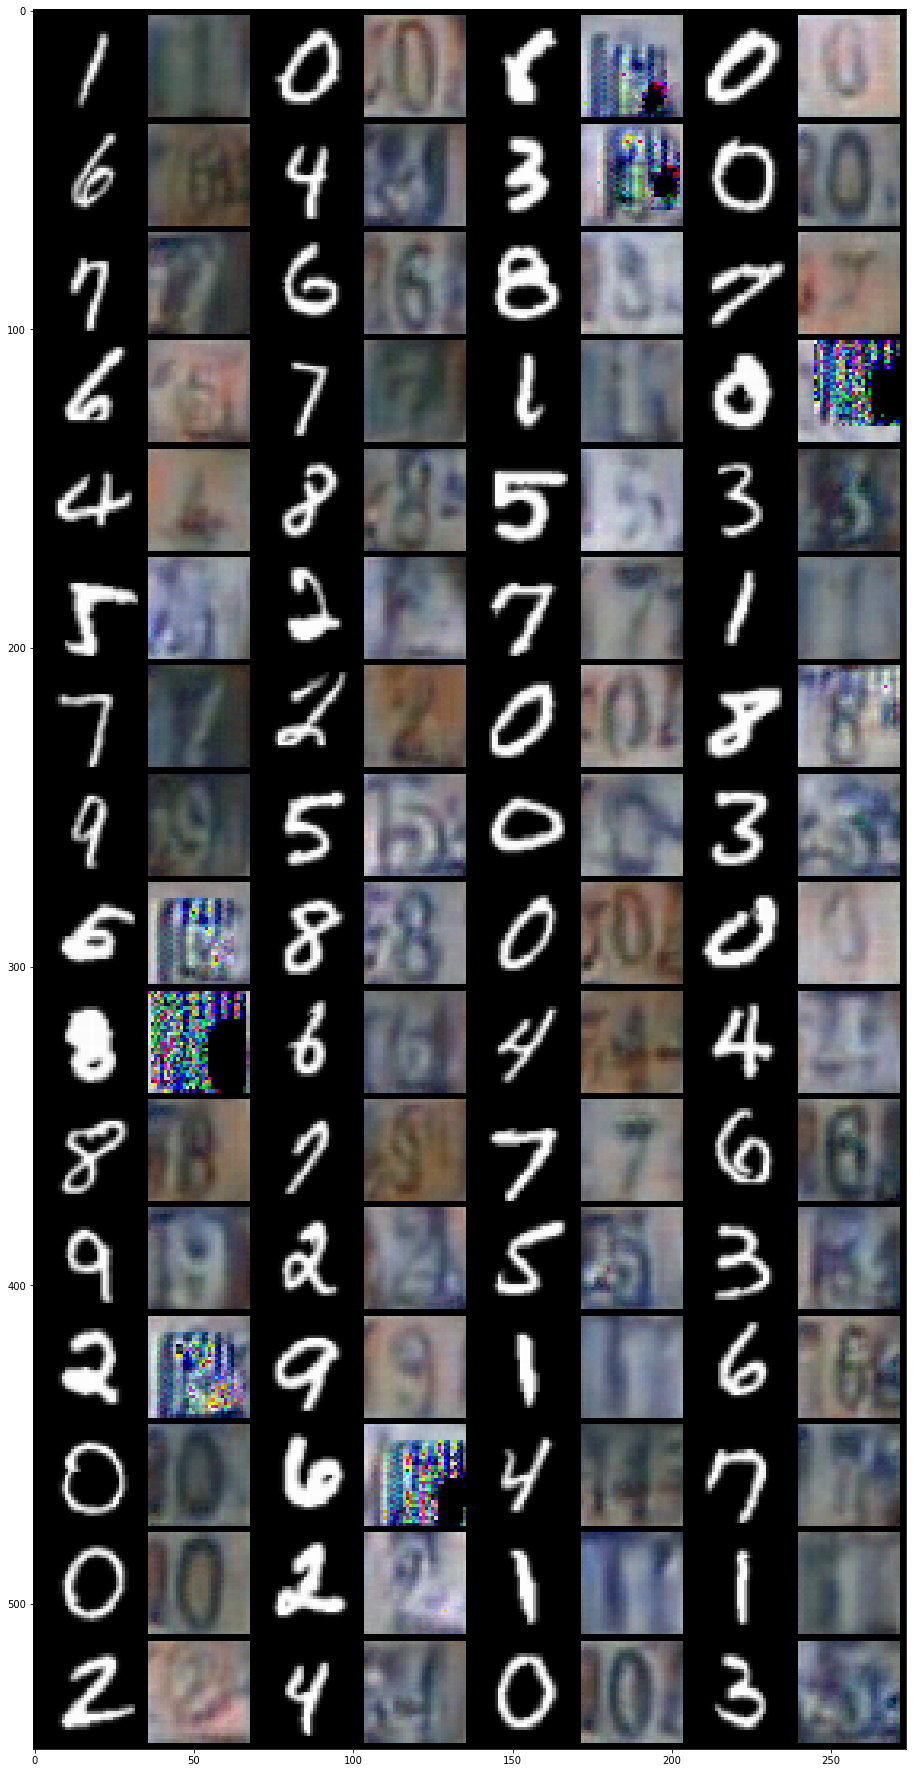

In [ ]:
plt.figure(figsize=(8*2,16*2))
plt.imshow(mergedm2s)

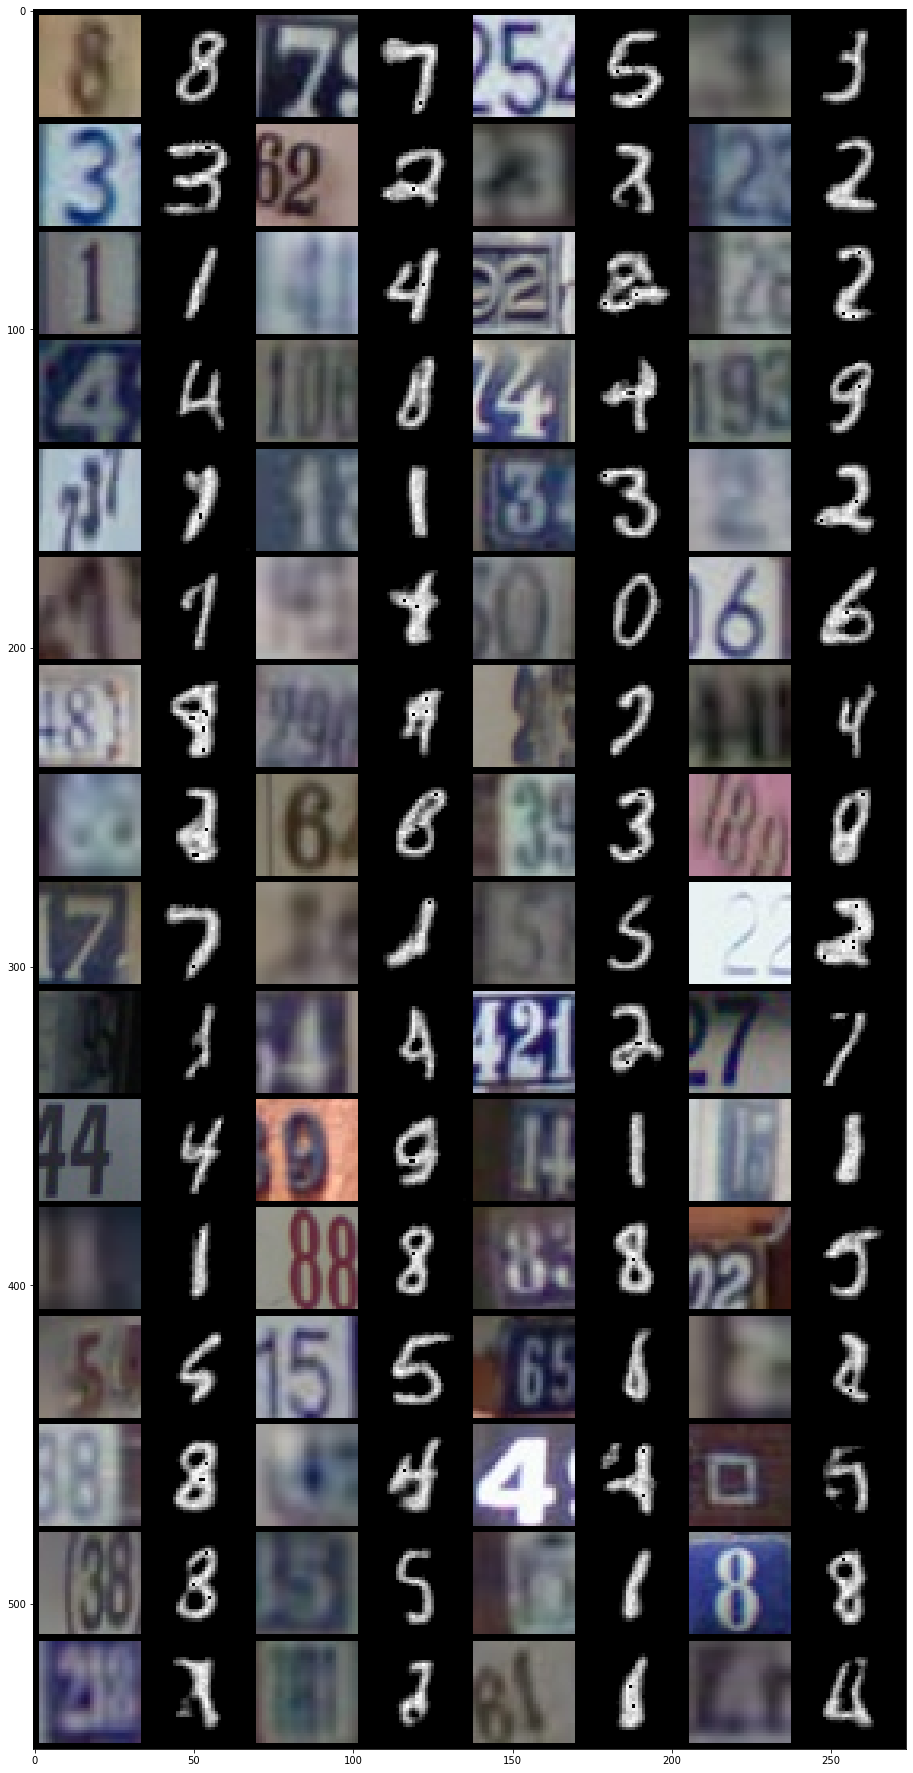

In [ ]:
plt.figure(figsize=(8*2,16*2))
plt.imshow(mergeds2m)